2025-04-11 18:57:45,769 - pyswarms.single.global_best - INFO - Optimize for 30 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|30/30, best_cost=-0.835
2025-04-11 18:59:07,879 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.835423197492163, best pos: [-0.52969799  0.87904419  0.34451598  0.3103549 ]


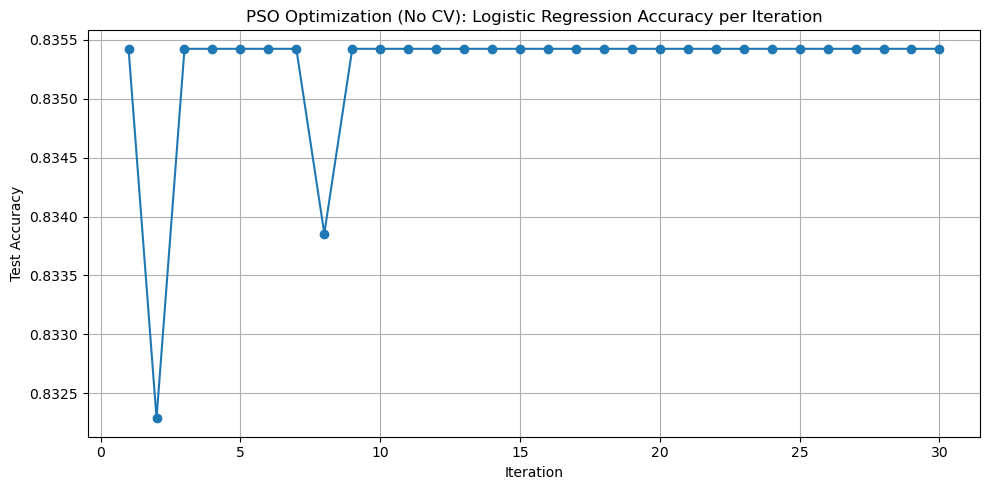

(0.5887827619913263, 'balanced', 'l1', 'liblinear', 0.835423197492163)

In [1]:
# Updated PSO objective function WITHOUT cross-validation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.metrics import accuracy_score
from pyswarms.single import GlobalBestPSO
from ucimlrepo import fetch_ucirepo

# Silence convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load dataset
dataset = fetch_ucirepo(id=69)
X_raw = dataset.data.features
y_raw = dataset.data.targets
X = OrdinalEncoder().fit_transform(X_raw)
y = LabelEncoder().fit_transform(y_raw.values.ravel())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Search options
penalty_options = ['l1', 'l2']
solver_options = ['liblinear', 'saga']
class_weight_options = [None, 'balanced']

# Bounds: [log_C, class_weight, penalty, solver]
lb = [np.log(0.001), 0, 0, 0]
ub = [np.log(100), 1, 1, 1]
bounds = (np.array(lb), np.array(ub))

# Accuracy tracking
accuracy_history = []

# Objective function without cross-validation
def objective_function_no_cv(swarm):
    results = []
    for params in swarm:
        try:
            C = np.exp(params[0])  # log-uniform
            class_weight = class_weight_options[int(round(params[1]))]
            penalty = penalty_options[int(round(params[2]))]
            solver = solver_options[int(round(params[3]))]

            if penalty == 'l1' and solver not in ['liblinear', 'saga']:
                results.append(1.0)
                continue

            model = LogisticRegression(
                C=C,
                penalty=penalty,
                solver=solver,
                class_weight=class_weight,
                max_iter=1000,
                random_state=42
            )
            model.fit(X_train, y_train)
            score = accuracy_score(y_test, model.predict(X_test))
            results.append(-score)
        except:
            results.append(1.0)
    best_score = -min(results)
    accuracy_history.append(best_score)
    return np.array(results)

# Run PSO
optimizer = GlobalBestPSO(
    n_particles=10,
    dimensions=4,
    options={'c1': 1.5, 'c2': 1.5, 'w': 0.5},
    bounds=bounds
)
cost, best_pos = optimizer.optimize(objective_function_no_cv, iters=30)

# Decode best parameters
best_C = np.exp(best_pos[0])
best_class_weight = class_weight_options[int(round(best_pos[1]))]
best_penalty = penalty_options[int(round(best_pos[2]))]
best_solver = solver_options[int(round(best_pos[3]))]

# Final model
model = LogisticRegression(
    C=best_C,
    penalty=best_penalty,
    solver=best_solver,
    class_weight=best_class_weight,
    max_iter=1000,
    random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)

# Plot convergence
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracy_history)+1), accuracy_history, marker='o')
plt.title("PSO Optimization (No CV): Logistic Regression Accuracy per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

(best_C, best_class_weight, best_penalty, best_solver, final_accuracy)
